In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
import re

sns.set_style("whitegrid")
%matplotlib inline

In [18]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
var_exp = pd.read_csv("Variable_explanations.csv")

In [19]:
display(train.head())
display(test.head())


,surveyid,village,survey_date,femaleres,age,married,children,hhsize,edu,hh_children,...,given_mpesa,amount_given_mpesa,received_mpesa,amount_received_mpesa,net_mpesa,saved_mpesa,amount_saved_mpesa,early_survey,depressed,day_of_week
0,926,91,23-Nov-61,1,28.0,1,4,6,10,0,...,0,0.0,0,0.000000,0.000000,1,0.000000,0,0,5
1,747,57,24-Oct-61,1,23.0,1,3,5,8,0,...,0,0.0,1,4.804611,4.804611,0,0.000000,0,1,3
2,1190,115,05-Oct-61,1,22.0,1,3,5,9,0,...,0,0.0,0,8.007685,8.007685,1,0.000000,0,0,5
3,1065,97,23-Sep-61,1,27.0,1,2,4,10,2,...,0,0.0,0,0.000000,0.000000,1,1.249199,0,0,0
4,806,42,12-Sep-61,0,59.0,0,4,6,10,4,...,0,0.0,0,0.000000,0.000000,0,0.000000,0,0,3


,surveyid,village,survey_date,femaleres,age,married,children,hhsize,edu,hh_children,...,given_mpesa,amount_given_mpesa,received_mpesa,amount_received_mpesa,net_mpesa,saved_mpesa,amount_saved_mpesa,early_survey,depressed,day_of_week
0,901,181,14-Nov-61,1,21,0,3,4,10,3,...,0,0.0,0,0.0,0.0,1,0.000000,0,0.0,3
1,498,47,18-Sep-61,1,44,1,6,8,6,6,...,0,0.0,0,0.0,0.0,0,0.000000,0,0.0,2
2,710,8,03-Sep-61,1,23,1,1,3,7,1,...,0,0.0,0,0.0,0.0,1,0.080077,0,0.0,1
3,433,25,01-Nov-60,1,67,0,0,1,1,0,...,0,0.0,0,0.0,0.0,0,0.000000,1,1.0,3
4,44,2,18-May-60,1,40,1,4,6,7,4,...,0,0.0,0,0.0,0.0,0,0.000000,1,NaN,4


In [20]:
### Function to check for missing values

def check_missing(df):
    missing_cols = {}
    for index, col in enumerate(df.columns):
        if df[col].isnull().any():
            missing_perc = (df[col].isnull().sum() / df.shape[0]).round(2)
            unique_vals = df[col].nunique()
            missing_cols[col] = [missing_perc, unique_vals] 

    #print(missing_cols)

    missing_df = pd.DataFrame.from_dict(missing_cols, orient = 'index').reset_index()
    
    if missing_df.shape[0] > 0:   #check the size of df and provide column names
        missing_df.columns = ['col', 'percent_missing', 'unique_values']
        ##sort the values
        missing_df = missing_df.sort_values(by= 'percent_missing', ascending = False)
        return missing_df
    else:
        return missing_df

### Clean Training Set

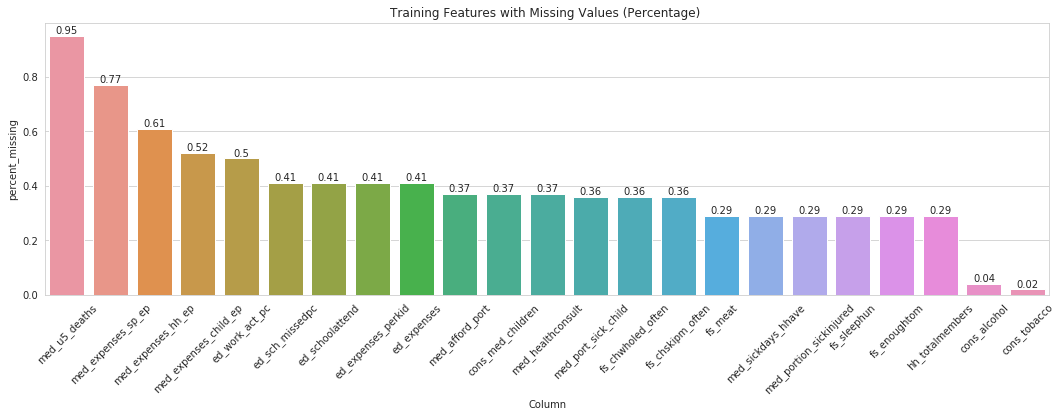

In [21]:
missing = check_missing(train)

plt.figure(figsize = (18, 5))
ax = sns.barplot(missing.col, missing.percent_missing)
bars = ax.patches
for bar, val in zip(bars, missing.percent_missing):
    h = bar.get_height()
    w = bar.get_width()
    xt = bar.get_x()
    ax.text(x= xt + w/2, y=h, s= val, ha='center', va='bottom')
plt.xticks(rotation = 45)
plt.title("Training Features with Missing Values (Percentage) ")
plt.xlabel("Column")
plt.show()

### Check correlation in the features above 0.7 to guide columns to drop

In [22]:
corr_matrix = train.corr().abs()
high_corr_var=np.where(corr_matrix>0.7)
high_corr_var=[(corr_matrix.columns[x],corr_matrix.columns[y]) for x,y in zip(*high_corr_var) if x!=y and x<y]

high_corr_var

[('children', 'hhsize'),
 ('children', 'hh_totalmembers'),
 ('hhsize', 'hh_totalmembers'),
 ('hh_children', 'hh_totalmembers'),
 ('cons_nondurable', 'cons_allfood'),
 ('asset_livestock', 'durable_investment'),
 ('asset_durable', 'durable_investment'),
 ('cons_allfood', 'cons_ownfood'),
 ('cons_ownfood', 'ent_animalstockrev'),
 ('cons_med_total', 'cons_med_children'),
 ('cons_med_children', 'med_expenses_child_ep'),
 ('cons_ed', 'ed_expenses'),
 ('cons_ed', 'ed_expenses_perkid'),
 ('ent_wagelabor', 'labor_primary'),
 ('ent_nonag_flowcost', 'ent_total_cost'),
 ('ent_nonag_flowcost', 'nondurable_investment'),
 ('ent_total_cost', 'nondurable_investment'),
 ('med_expenses_hh_ep', 'med_expenses_child_ep'),
 ('med_portion_sickinjured', 'med_port_sick_child'),
 ('ed_expenses', 'ed_expenses_perkid'),
 ('amount_received_mpesa', 'net_mpesa')]

In [23]:
train['age'] = train['age'].apply(lambda x: np.ceil(x))

##aggregate medical expenses
train['med_expenses_child_ep'].fillna(value = 0, inplace = True)
train['med_expenses_sp_ep'].fillna(value = 0, inplace = True)
train[['med_expenses_child_ep', 'med_expenses_sp_ep']].isnull().any()
train['med_expenses_hh_ep'] = train.loc[train[(train.med_expenses_hh_ep.isnull()) & 
     (~train.med_expenses_sp_ep.isnull()) & (~train.med_expenses_child_ep.isnull())].index,
          'med_expenses_hh_ep'] = train.med_expenses_sp_ep + train.med_expenses_child_ep

#check the aggregated column
train['med_expenses_hh_ep'].isnull().sum()
#drop the aggregated columns
train.drop(['med_expenses_child_ep', 'med_expenses_sp_ep'], axis = 1, inplace = True)


##combine substance abuse to one column then drop the components
train['substance'] = train['cons_alcohol'] + train['cons_tobacco']
train.drop(['cons_tobacco', 'cons_alcohol'], axis = 1, inplace = True)
train['substance'].fillna(value = 0, inplace = True)


train.drop('med_afford_port', axis = 1, inplace = True)

train['med_healthconsult'] = train.groupby("depressed").transform(lambda x: x.fillna(x.mode()))

train.loc[train[(train['ed_sch_missedpc'].isnull()) & (train['ed_schoolattend'].isnull())].index, 
          'ed_sch_missedpc'] = 0.0

###impute missing values by class mean or mode 
train['ed_work_act_pc'] = train.groupby("depressed").transform(lambda x: x.fillna(x.mean()))
train['ed_schoolattend'] = train.groupby("depressed").transform(lambda x: x.fillna(x.mean()))
train['ed_sch_missedpc'].fillna(value = 0, inplace = True)
train['med_portion_sickinjured'] = train.groupby("depressed").transform(lambda x: x.fillna(x.mean()))
train['med_u5_deaths'] = train.groupby("depressed").transform(lambda x: x.fillna(x.mode()))
train['fs_enoughtom'] = train.groupby("depressed").transform(lambda x: x.fillna(x.mode()))


train.loc[train[(train['fs_chskipm_often'].isnull()) & (~train['fs_adskipm_often'].isnull())].index, 
    'fs_chskipm_often'] = train['fs_adskipm_often']

##columns to drop either due to high correlation or alot of mising values
drop_col = ['hh_totalmembers', 'hhsize', 'amount_received_mpesa', 'cons_allfood'
            'ed_expenses', 'cons_alcohol', 'cons_tobacco', 'hh_totalmembers', 
            'asset_livestock', 'cons_med_children', 'ed_expenses_perkid', 'ed_expenses',
            'cons_ownfood', 'fs_sleephun', 'med_port_sick_child', 'fs_meat', 
            'ent_nonag_flowcost', 'nondurable_investment', 'fs_chwholed_often'
            'med_sickdays_hhave', 'fs_chwholed_often', 'med_sickdays_hhave'
           ]

#missing_df.drop([i for i in drop_col if i in missing_df], axis = 1).col.unique()
train.drop([i for i in drop_col if i in train.columns], axis = 1, inplace = True)

###check if there is any missing values in the df
check_missing(train)#.col.unique()

,index


### Exploratory Data Analysis

In [24]:
train.drop(['day_of_week', 'surveyid'], axis = 1).describe(include = ['int']).T.round(4)

,count,mean,std,min,25%,50%,75%,max
village,1143.0,76.4094,66.7881,1.0,23.0,57.0,105.5,292.0
femaleres,1143.0,0.9169,0.2762,0.0,1.0,1.0,1.0,1.0
married,1143.0,0.7725,0.4194,0.0,1.0,1.0,1.0,1.0
children,1143.0,2.8600,1.8469,0.0,2.0,3.0,4.0,10.0
edu,1143.0,8.7358,2.8672,1.0,8.0,9.0,10.0,19.0
hh_children,1143.0,2.0184,2.0167,0.0,0.0,2.0,3.0,10.0
asset_niceroof,1143.0,0.0009,0.0296,0.0,0.0,0.0,0.0,1.0
ent_wagelabor,1143.0,0.1864,0.3896,0.0,0.0,0.0,0.0,1.0
ent_ownfarm,1143.0,0.2476,0.4318,0.0,0.0,0.0,0.0,1.0
ent_business,1143.0,0.1076,0.3100,0.0,0.0,0.0,0.0,1.0


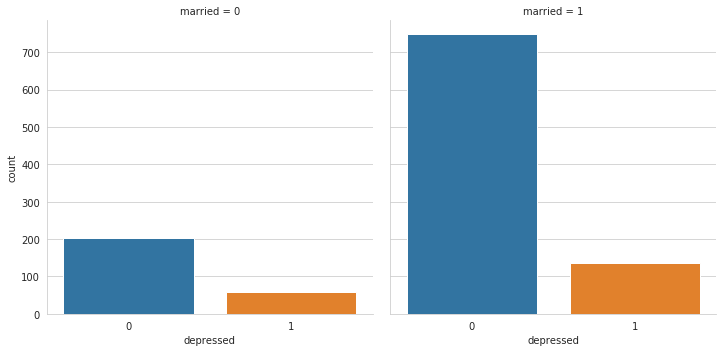

In [25]:
sns.catplot('depressed', col= 'married', kind = 'count', data = train)
plt.show()

- More married couples are depressed compared to those who are not reported married

<Figure size 360x432 with 0 Axes>

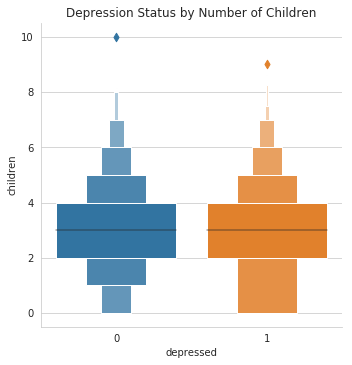

In [61]:
plt.figure(figsize = (5, 6))
sns.catplot(y = 'children', x = 'depressed', kind = 'boxen',  data = train)
plt.title("Depression Status by Number of Children")
plt.show()

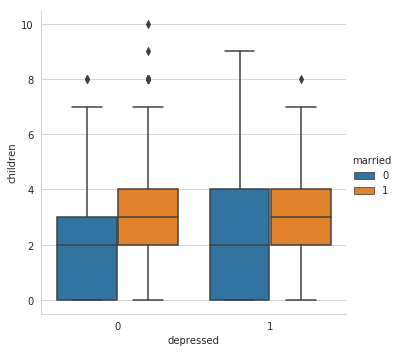

In [27]:
sns.catplot(y = 'children', x = 'depressed', hue = 'married', kind = 'box', data = train)
plt.show()

- On average most respondents reported having between 2 - 4 children
- The number of children seems not to be a majore influencing factor on the depression status

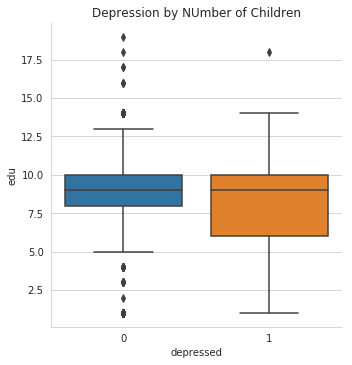

In [28]:
sns.catplot(y = 'edu', x = 'depressed', kind = 'box', data = train)
plt.title("Depression by NUmber of Children")
plt.show()

- Mean Education years stands at around 8.5 years
- Most of those recorded as depressed barely had education between 6 - 10 years

In [29]:
train.describe(include = ['float']).T.round(4)

,count,mean,std,min,25%,50%,75%,max
age,1143.0,34.5486,13.7416,17.0000,24.0,30.0000,41.0000,91.0000
cons_nondurable,1143.0,128.4076,140.1600,0.0000,0.0,107.3888,188.5324,1431.6091
asset_durable,1143.0,148.5713,198.4220,0.0000,0.0,121.7168,221.8930,3720.3704
asset_phone,1143.0,19.6568,28.0531,0.0000,0.0,0.0000,32.0307,192.1844
asset_savings,1143.0,10.2541,79.8085,0.0000,0.0,0.0000,0.0000,2242.1519
asset_land_owned_total,1143.0,0.9269,1.6638,0.0000,0.0,0.0000,1.5000,27.0000
cons_allfood,1143.0,95.8060,114.4873,0.0000,0.0,77.1083,136.8410,1386.9663
cons_med_total,1143.0,2.6904,12.1410,0.0000,0.0,0.0000,0.0000,206.5983
cons_ed,1143.0,2.7948,8.3318,0.0000,0.0,0.4671,2.4023,133.4614
cons_social,1143.0,3.6478,7.5749,0.0000,0.0,1.2812,3.8170,140.1345


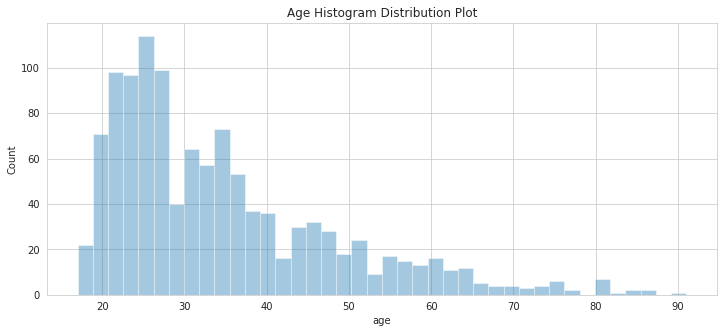

In [30]:
plt.figure(figsize = (12, 5))
sns.distplot(train.age, hist = True, kde = False, bins = 40)
plt.title('Age Histogram Distribution Plot')
plt.ylabel("Count")

plt.show()

- Most of the respondents are of age 40 and below with the modal class being around 25

### <h2 style= 'color': 'blue'> Building the Model </h2>

In [31]:
from sklearn.model_selection import train_test_split
from xgboost.sklearn import XGBClassifier
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
import warnings
warnings.filterwarnings('ignore')

train[['fs_enoughtom', 'med_healthconsult', 
       'med_u5_deaths']]=train[['fs_enoughtom',
                                'med_healthconsult', 'med_u5_deaths']].astype('int')

#train_data=pd.read_csv('datasets/train.csv')
#print(train_data.head())
# remove unnecessary fields for model training
unnecessary_fields=['day_of_week','early_survey','surveyid','village','survey_date','fs_meat']
train.drop([i for i in unnecessary_fields if i in train],axis=1, inplace = True)
X=train.drop('depressed',axis=1)
y=train['depressed']
# training harness
models = []
models.append(('LR', LogisticRegression()))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC()))
models.append(('RF', RandomForestClassifier()))
models.append(('XGB', XGBClassifier()))
# evaluate each model in turn
results = []
names = []
for name, model in models:
    kfold = model_selection.KFold(n_splits=10, random_state=25)
    cv_results = model_selection.cross_val_score(model, X, y, cv=kfold, scoring='accuracy')
    results.append(cv_results)
    names.append(name)

    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)


LR: 0.820686 (0.029735)
LDA: 0.817193 (0.027346)
KNN: 0.806682 (0.028313)
CART: 0.726110 (0.038360)
NB: 0.217841 (0.031192)
SVM: 0.831182 (0.032422)
RF: 0.819809 (0.033203)
XGB: 0.820694 (0.030509)


### Use GridSearchCV for hyper parameter tuning

In [32]:
from sklearn.model_selection import GridSearchCV
from pprint import pprint

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0) 
forest = RandomForestClassifier()

params = {'n_estimators': [10, 100, 200, 300, 400, 500],
          'criterion': ['gini'],
          'max_depth' :[80, 90, 100, 110], 
          'max_features':  [2, 3], 
          'min_samples_leaf': [3, 4, 5], 
          'min_samples_split': [8, 10, 12], 
          }
gridcv = GridSearchCV(forest, param_grid =  params, cv = 3)

gridcv.fit(X, y)

display(pprint(gridcv.best_params_))

#display(grid.feature_importances)

{'criterion': 'gini',
 'max_depth': 80,
 'max_features': 3,
 'min_samples_leaf': 3,
 'min_samples_split': 8,
 'n_estimators': 300}


None

In [54]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state =  0)

rf = RandomForestClassifier(n_estimators = 10, 
                            min_samples_split = 8,
                            min_samples_leaf = 3, 
                            #max_features= 3,
                            max_depth=80, 
                            random_state = 0)

rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

acc = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)


print('accuray:' , acc)
print('roc_auc:', roc_auc)
print('\nconfusion_matrix:')
display(cm)

accuray: 0.851528384279476
roc_auc: 0.49744897959183676

confusion_matrix:


array([[195,   1],
       [ 33,   0]])

### Clean Test Data

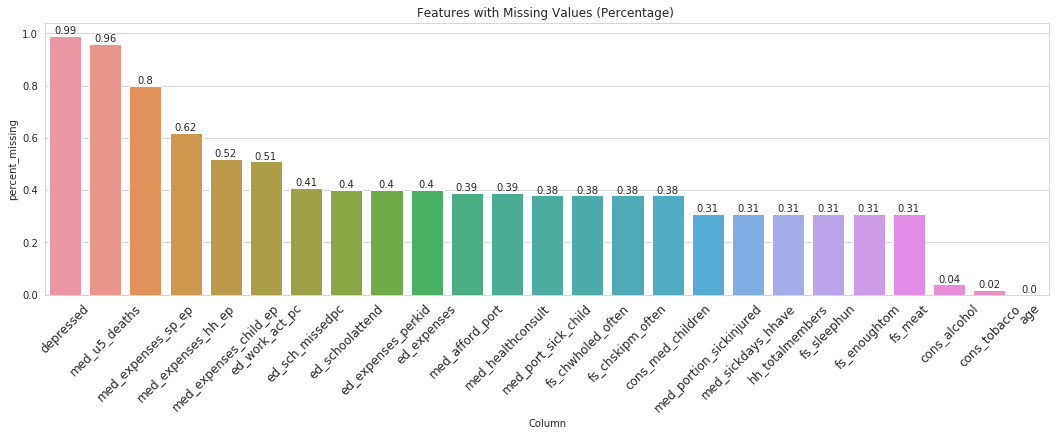

In [34]:
missing = check_missing(test)

plt.figure(figsize = (18, 5))
ax = sns.barplot(missing.col, missing.percent_missing)
bars = ax.patches
for bar, val in zip(bars, missing.percent_missing):
    h = bar.get_height()
    w = bar.get_width()
    xt = bar.get_x()
    ax.text(x= xt + w/2, y=h, s= val, ha='center', va='bottom')
plt.xticks(rotation = 45, fontsize= 12)
plt.title("Features with Missing Values (Percentage) ")
plt.xlabel("Column")
plt.show()

In [35]:
#FUNCTION TO IMPUTE THE AGE
def fill_age(i):
    i = str(i).strip()
    if len(re.sub(r'[^\d+]', "", i)) == 0:      # NO NUMERIC VALUES
        val = 25
    elif re.search(r'[\d+\.]+', i):             # IF YOU FIND NUMBER AND DECIMAL
        val = re.search(r'[\d+]+', i).group()
        val = int(val) + 1
    else:
        val = val
    return val


test.med_expenses_child_ep.fillna(value = 0, inplace = True)
test.med_expenses_sp_ep.fillna(value = 0, inplace = True)

test[['med_expenses_child_ep', 'med_expenses_sp_ep']].isnull().any()
test['med_expenses_hh_ep'] = test.loc[test[(test.med_expenses_hh_ep.isnull()) & 
     (~test.med_expenses_sp_ep.isnull()) & (~test.med_expenses_child_ep.isnull())].index,
          'med_expenses_hh_ep'] = test.med_expenses_sp_ep + test.med_expenses_child_ep

test['med_expenses_hh_ep'].isnull().sum()

test.drop(['med_expenses_child_ep', 'med_expenses_sp_ep'], axis = 1, inplace = True)

##combine the substance abuse columns and drop the component columns
test['substance'] = test['cons_alcohol'] + test['cons_tobacco']
test.drop(['cons_tobacco', 'cons_alcohol'], axis = 1, inplace = True)
test['substance'].fillna(value = 0, inplace = True)

test.drop('med_afford_port', axis = 1, inplace = True)

test.loc[test[(test['fs_chskipm_often'].isnull()) & (~test['fs_adskipm_often'].isnull())].index, 
    'fs_chskipm_often'] = test['fs_adskipm_often']

test['med_u5_deaths'].fillna(value = 0,inplace = True)
test['ed_work_act_pc'].fillna(value = test['ed_work_act_pc'].mean() , inplace = True)
test['ed_sch_missedpc'].fillna(value = test['ed_sch_missedpc'].mean() , inplace = True)
test['age'] = test['age'].apply(fill_age).astype(float) #.fillna(test['age'].astype(float).mode())

test['fs_enoughtom'].fillna(value = test['fs_enoughtom'].mean() , inplace = True)
test['med_portion_sickinjured'].fillna(value = test['med_portion_sickinjured'].mean(), inplace = True)
test['ed_schoolattend'].fillna(value = test['ed_schoolattend'].mean(), inplace = True)
test['med_healthconsult'].fillna(value = test['med_healthconsult'].mean(), inplace = True)



#ALIGN THE TRAIN AND TEST SETS
train, test = train.align(test, join = 'left', axis = 1)

##drop the depressed column from train dataset
test.drop('depressed', axis = 1 , inplace = True)

##make sure the unnecessary columns are dropped
unnecessary_fields=['day_of_week','early_survey','surveyid','village','survey_date','fs_meat']
test.drop([i for i in unnecessary_fields if i in test],axis=1, inplace = True)


test[['fs_enoughtom', 'med_healthconsult', 
       'med_u5_deaths']]=test[['fs_enoughtom',
                                'med_healthconsult', 'med_u5_deaths']].astype('int')

In [53]:
rf = RandomForestClassifier(n_estimators = 10, 
                            min_samples_split = 8,
                            min_samples_leaf = 3, 
                            max_depth=90, 
                            random_state = 0)

rf.fit(X, y)
y_pred = rf.predict(test)

### Make a Submision File

In [48]:

#Get the surveyids
submission = pd.read_csv('test.csv', usecols = ['surveyid'])

#add the prediction values
submission.insert(1, "depressed", y_pred)

#visualize the first 5 rows
#submission.head()

#save the submission file
submission.to_csv("Submission.csv", index = None)

In [49]:
submission.depressed.value_counts()

0    286
Name: depressed, dtype: int64

- None of the test respondents is predicted depressed